referenced:

https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting

ARIMA, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
    
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True) 

df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

In [3]:
# model data preprocessing
# split
train, test = ts.split_after(pd.Timestamp("05.01.2023 00:00"))

## DARTS ML

### 1. A less naive model

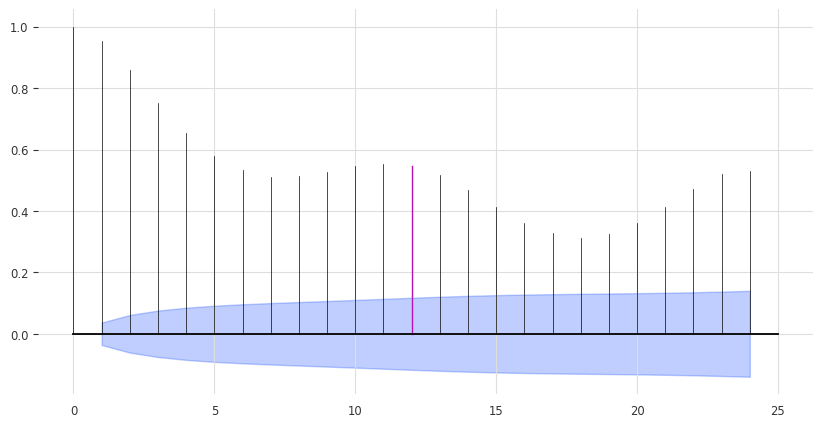

In [4]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, max_lag = 24, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(train, m=12, max_lag = 24, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [ ]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=3)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test_scaled))

ts.plot(label="actual", alpha=0.05)
seasonal_forecast.plot(label="naive forecast (K=3)", alpha=0.05)

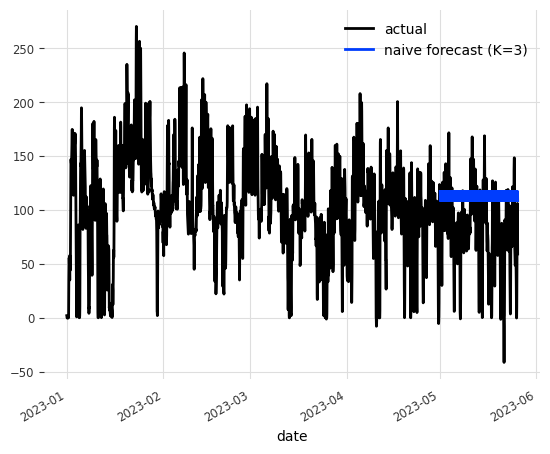

In [6]:
from darts.metrics import mape
from darts.metrics import rmse
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=3)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

ts.plot(label="actual", alpha=0.05)
seasonal_forecast.plot(label="naive forecast (K=3)", alpha=0.05)

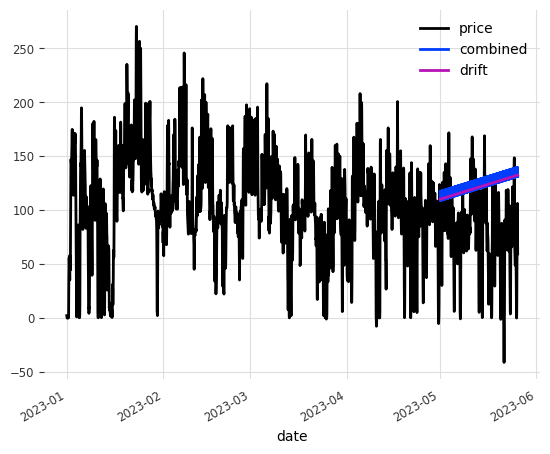

In [8]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

ts.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [9]:
from darts.metrics import rmse

print(
    "Root Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        rmse(ts, combined_forecast)))

Root Mean absolute percentage error for the combined naive drift + seasonal: 57.36%.


In [10]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(ts))
    print("model {} obtains RMSE: {:.2f}%".format(model, rmse(ts, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
# eval_model(Theta())

model ExponentialSmoothing() obtains RMSE: 448.14%
model TBATS() obtains RMSE: 35.47%
model AutoARIMA() obtains RMSE: 36.26%


  0%|          | 0/1391 [00:00<?, ?it/s]

RMSE = 23.81%


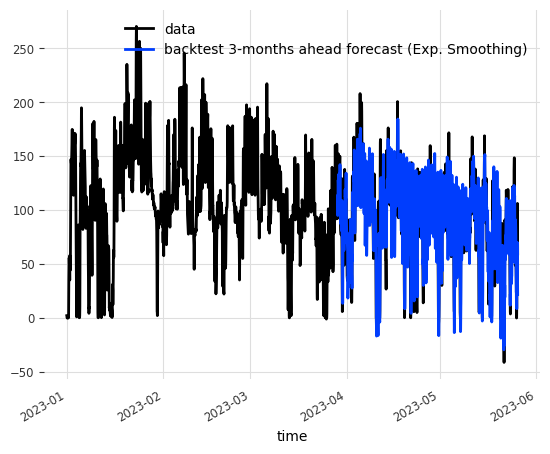

In [12]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    ts, start=0.6, forecast_horizon=3, verbose=True
)

ts.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("RMSE = {:.2f}%".format(rmse(historical_fcast_es, ts)))

In [18]:
# it takes long time, so I stop the training!

from darts import TimeSeries
from darts.models import TBATS

model_tbats = TBATS()
historical_forecast_tbats = model_tbats.historical_forecasts(
    series=ts, start=0.6, forecast_horizon=3, verbose=True)

ts.plot(label="data")
historical_forecast_tbats.plot(label="backtest 3-months ahead forecast (Theta)")
print("RMSE = {:.2f}%".format(rmse(historical_forecast_tbats, ts)))

  0%|          | 0/1391 [00:00<?, ?it/s]

KeyboardInterrupt: 

### The meaning of p, d and q in ARIMA model
* AR(p) Autoregression : p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.
* I(d) Integration : d is the minimum number of differencing needed to make the series stationary.
* MA(q) Moving Average:  q is the order of the Moving Average (MA) term

In [32]:
import pandas as pd
import numpy as np
from darts import TimeSeries
# 
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test) from the stats models package. The reason is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

so we assume, our data is stationary! our p-value is 0

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

df_el['date'] = pd.to_numeric(df_el['date'], errors='coerce')

result = adfuller(df_el['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.429957
p-value: 0.000000


### find out AR(p) Autoregression

#### P = 1

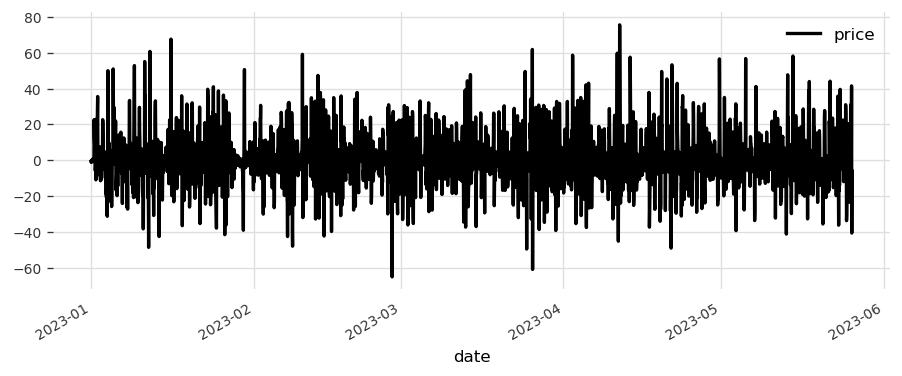

In [11]:
ts.diff().plot()

We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

### find out q
we will use q is o

KeyboardInterrupt: 

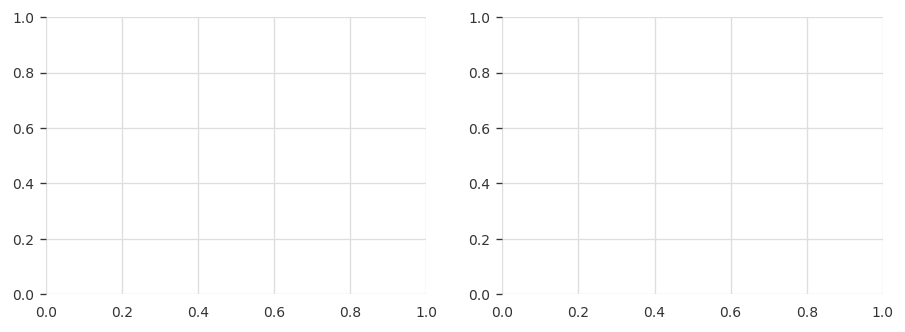

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ts.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(ts.diff(), ax=axes[1])

plt.show()

In [30]:
from darts.models import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, p=1, d=1, q=0, random_state=0, add_encoders=None)
model_fit = model.fit(train)
prediction = model.predict(len(test))

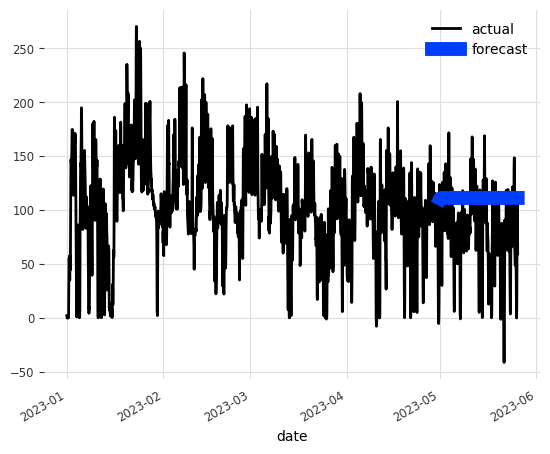

In [33]:
# historical data analysis
ts.plot(label = 'actual')
prediction.plot(label = 'forecast', lw = 10)
plt.legend()

In [34]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(test))

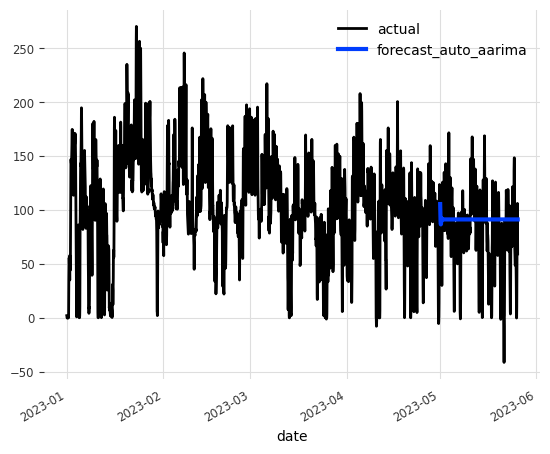

In [35]:
ts.plot(label = 'actual')
prediction_aarima.plot(label = 'forecast_auto_aarima', lw = 3)
plt.legend()